<ipython-input-2-89c464549e9f>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsHoliday'] = data['IsHoliday'].astype(int)


Model Evaluation Results:
               Model      RMSE       MAE        R2
0  Linear Regression  0.120606  0.084675  0.673215
1      Random Forest  0.031119  0.015706  0.978244
2                KNN  0.084425  0.031736  0.839874
3            XGBoost  0.057102  0.036970  0.926748


<ipython-input-2-89c464549e9f>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette='coolwarm')


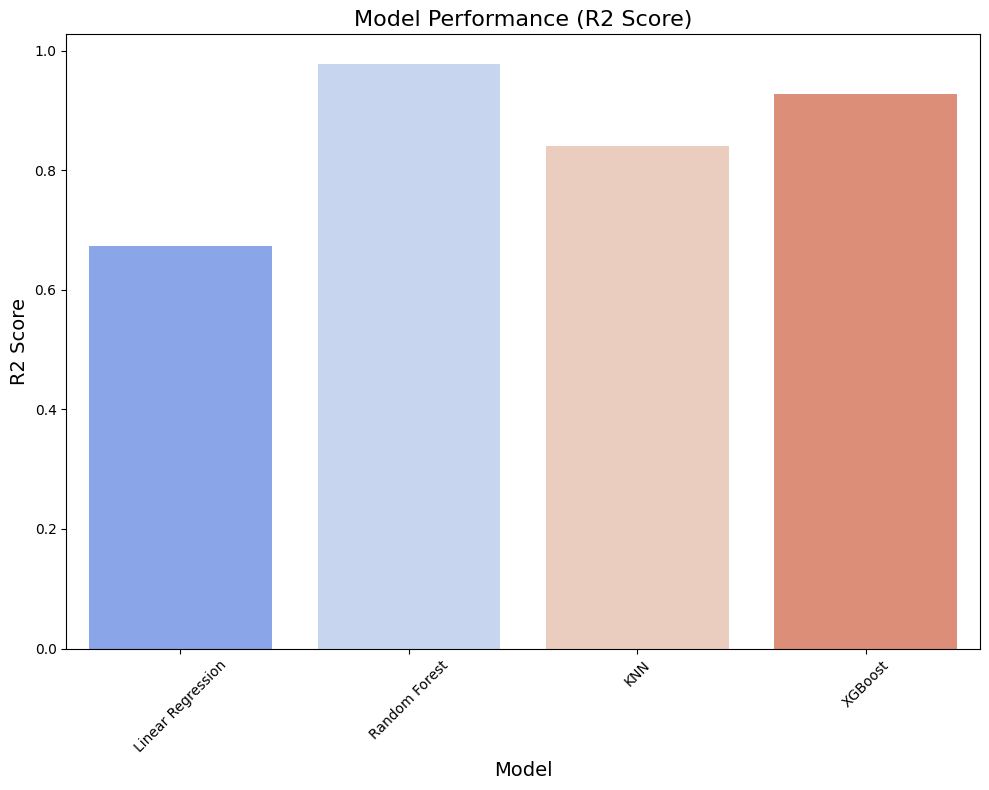

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Load the data
data = pd.read_csv('/content/train.csv')
stores = pd.read_csv('/content/stores.csv')
features = pd.read_csv('/content/features.csv')

# Fill missing values
features['CPI'] = features['CPI'].fillna(features['CPI'].median())
features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].median())

for i in range(1, 6):
    features[f"MarkDown{i}"] = features[f"MarkDown{i}"].apply(lambda x: 0 if x < 0 else x)
    features[f"MarkDown{i}"] = features[f"MarkDown{i}"].fillna(0)

# Merge datasets
data = pd.merge(data, features, on=['Store', 'Date'], how='left')
data = pd.merge(data, stores, on='Store', how='left')

# Convert 'Date' to datetime and sort
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.sort_values(by=['Date'], inplace=True)

# If 'Date' is an index, reset it
if 'Date' not in data.columns:
    data.reset_index(inplace=True)

# Create additional time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

# Check and drop the duplicate 'IsHoliday' columns
if 'IsHoliday_x' in data.columns and 'IsHoliday_y' in data.columns:
    data.drop(columns='IsHoliday_x', inplace=True)
    data.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

# Create 'Total_MarkDown' and drop individual MarkDown columns
data['Total_MarkDown'] = data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1)
data.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

# Filter outliers using Z-score
numeric_col = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown']
data = data[(np.abs(stats.zscore(data[numeric_col])) < 2.5).all(axis=1)]

# Remove negative sales
data = data[data['Weekly_Sales'] >= 0]

# Convert 'IsHoliday' to integer
data['IsHoliday'] = data['IsHoliday'].astype(int)

# One-hot encode categorical variables
cat_col = ['Store', 'Dept', 'Type']
data = pd.get_dummies(data, columns=cat_col)

# Normalize numeric columns
num_col = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown']
scaler = MinMaxScaler()
data[num_col] = scaler.fit_transform(data[num_col])

# Split features and target variable
X = data.drop(columns=['Weekly_Sales', 'Date'], errors='ignore')
y = data['Weekly_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(n_neighbors=1),
    'XGBoost': XGBRegressor()
}

# Evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.explained_variance_score(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='R2', data=results_df, palette='coolwarm')
plt.title('Model Performance (R2 Score)', fontsize=16)
plt.ylabel('R2 Score', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


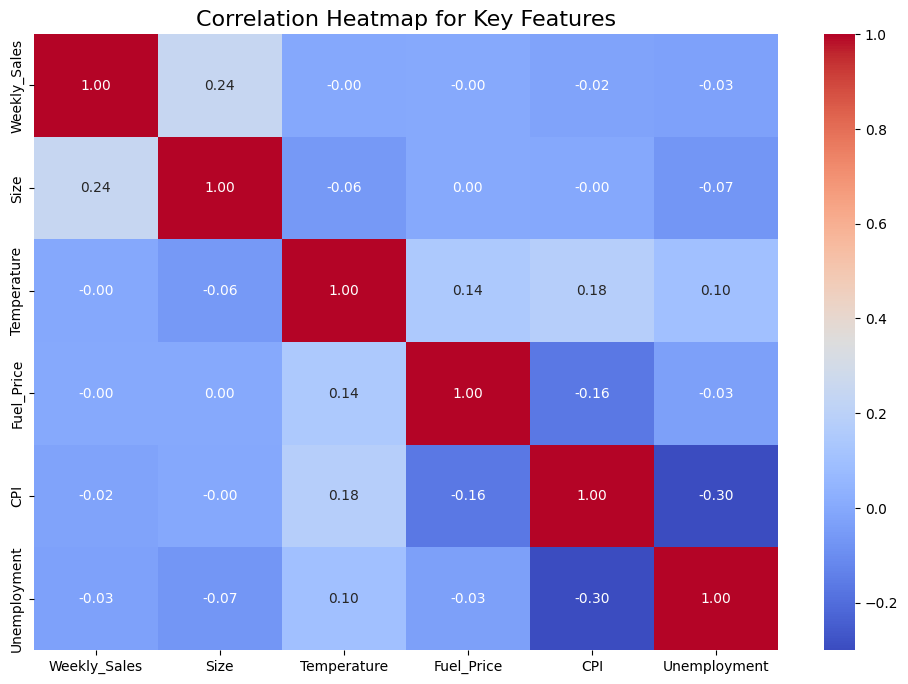

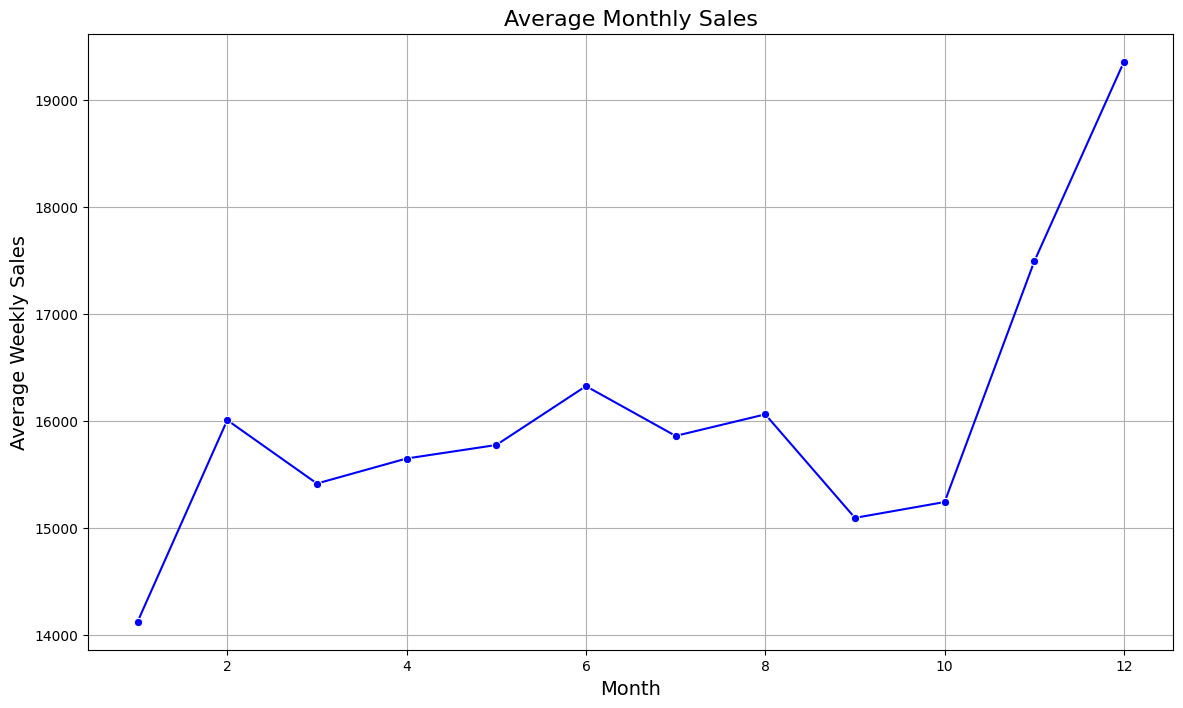

<ipython-input-7-48e3a9f6ac2e>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Store', y='Weekly_Sales', data=data, showfliers=False, palette='coolwarm')


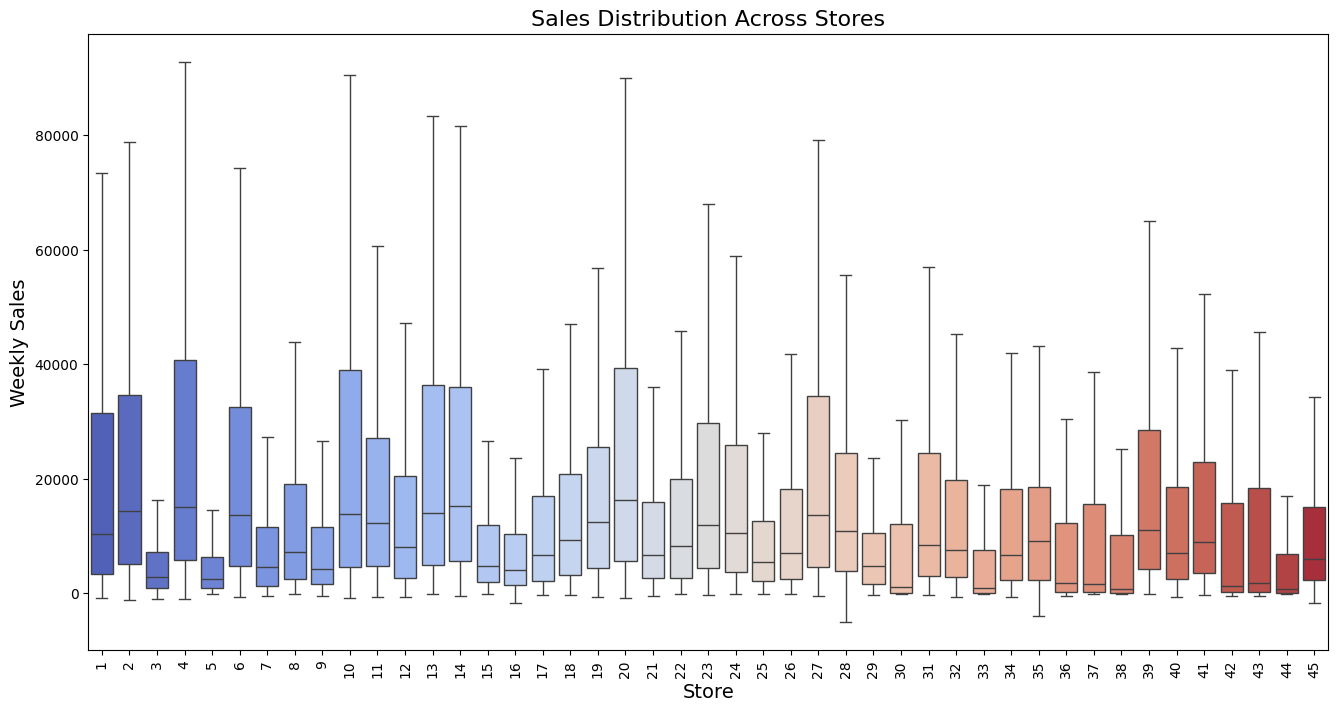

<ipython-input-7-48e3a9f6ac2e>:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_sales = data['Weekly_Sales'].resample('M').mean()


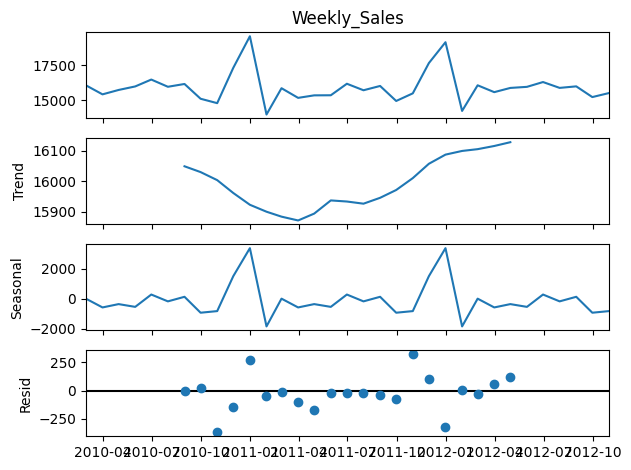

<ipython-input-7-48e3a9f6ac2e>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Dept', y='Weekly_Sales', data=data, estimator='mean', ci=None, palette='viridis')
<ipython-input-7-48e3a9f6ac2e>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dept', y='Weekly_Sales', data=data, estimator='mean', ci=None, palette='viridis')


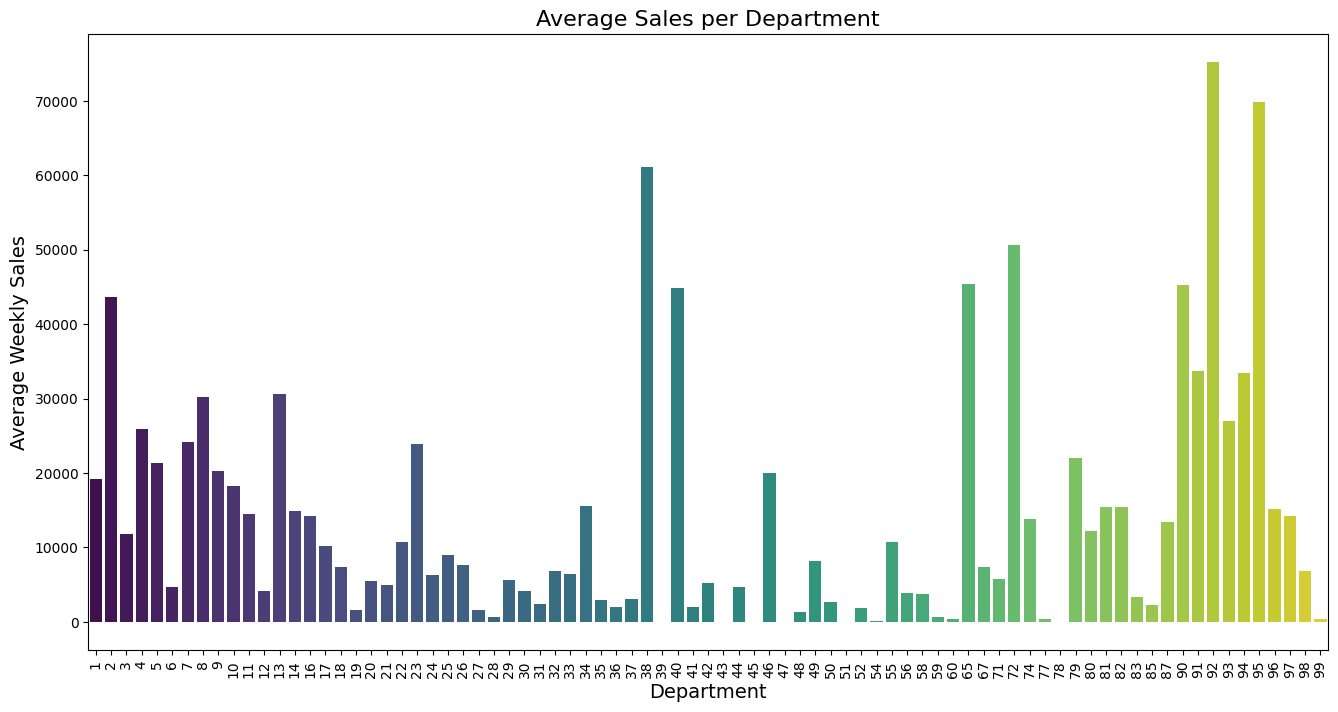

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load the data
data = pd.read_csv('/content/train.csv')
stores = pd.read_csv('/content/stores.csv')
features = pd.read_csv('/content/features.csv')

# Merge datasets
data = pd.merge(data, features, on=['Store', 'Date'], how='left')
data = pd.merge(data, stores, on='Store', how='left')

# Convert 'Date' to datetime and add time-based features
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = data[['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for Key Features', fontsize=16)
plt.show()

# Average Monthly Sales
monthly_sales = data.groupby('Month')['Weekly_Sales'].mean()
plt.figure(figsize=(14, 8))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', color='b')
plt.title('Average Monthly Sales', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Weekly Sales', fontsize=14)
plt.grid()
plt.show()


# Store-wise Sales Distribution
plt.figure(figsize=(16, 8))
sns.boxplot(x='Store', y='Weekly_Sales', data=data, showfliers=False, palette='coolwarm')
plt.title('Sales Distribution Across Stores', fontsize=16)
plt.xlabel('Store', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.xticks(rotation=90)
plt.show()

# Time Series Decomposition
data.set_index('Date', inplace=True)
weekly_sales = data['Weekly_Sales'].resample('M').mean()
sm.tsa.seasonal_decompose(weekly_sales, model='additive').plot()
plt.show()

# Department-wise Average Sales
plt.figure(figsize=(16, 8))
sns.barplot(x='Dept', y='Weekly_Sales', data=data, estimator='mean', ci=None, palette='viridis')
plt.title('Average Sales per Department', fontsize=16)
plt.xlabel('Department', fontsize=14)
plt.ylabel('Average Weekly Sales', fontsize=14)
plt.xticks(rotation=90)
plt.show()
